Visualize the distribution of embeddings extracted by the self-supervised model using t-SNE.
To learn more about t-SNE, see [this interactive site](https://distill.pub/2016/misread-tsne/)

In [69]:
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn.functional as F
from lightly.data import LightlyDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm

from dpat.data import PMCHHGImageDataset
from dpat.extract_features.models import SwAV

In [70]:
# Make dimensionality reductions reproducible.
sklearn.random.seed(42)
_ = torch.random.manual_seed(42)

In [71]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    targets = []
    with torch.no_grad():
        for img, target, _ in tqdm(dataloader, total=len(dataloader), desc="Extracting features"):
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            targets.extend(target)

    embeddings = torch.cat(embeddings, 0)
    embeddings = F.normalize(embeddings)
    return embeddings, targets

In [72]:
model = SwAV.load_from_checkpoint(
    "/scistor/guest/sjg203/projects/pmc-hhg/dpat/checkpoints/swav-epoch=199-step=39200.ckpt"
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
fold = "val"
root_dir = "/scistor/guest/sjg203/projects/pmc-hhg/images-tif"
dataset = LightlyDataset.from_torch_dataset(
    PMCHHGImageDataset(
        root_dir=root_dir,
        image_paths_and_targets="/scistor/guest/sjg203/projects/pmc-hhg/images-tif/"
        "splits/"
        "medulloblastoma+pilocytic-astrocytoma_"
        f"pmc-hhg_{fold}-subfold-0-fold-0.csv",
        mpp=0.2,
        tile_size_x=224,
        tile_size_y=224,
        tile_overlap_x=0,
        tile_overlap_y=0,
        tile_mode="overflow",
        crop=False,
        mask_factory="no_mask",
        mask_foreground_threshold=None,
        mask_root_dir=None,
        transform=Compose([ToTensor()]),
    )
)
dataloader = DataLoader(dataset, batch_size=32)

In [73]:
model.eval()
embeddings, targets = generate_embeddings(model, dataloader)

Extracting features: 100%|██████████| 657/657 [00:35<00:00, 18.56it/s]


In [74]:
# Following the recommendation at https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# to first use PCA to reduce the number of dimensions to a reasonable amount.
pca = PCA(50)
pca_embeddings = pca.fit_transform(embeddings.cpu())

In [75]:
tsne = TSNE()
tsne_embeddings = tsne.fit_transform(pca_embeddings)

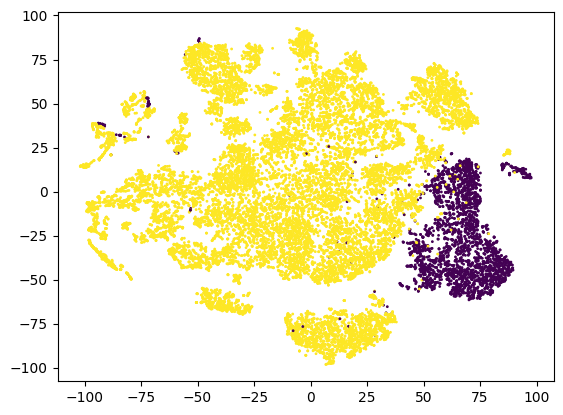

In [76]:
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=1, c=targets)
plt.show()

Doing the above with an untrained model

Extracting features: 100%|██████████| 657/657 [00:36<00:00, 17.88it/s]


Calculating principal components...
Performing T-distributed Stochastic Neighbor Embedding...
Plotting t-SNE...


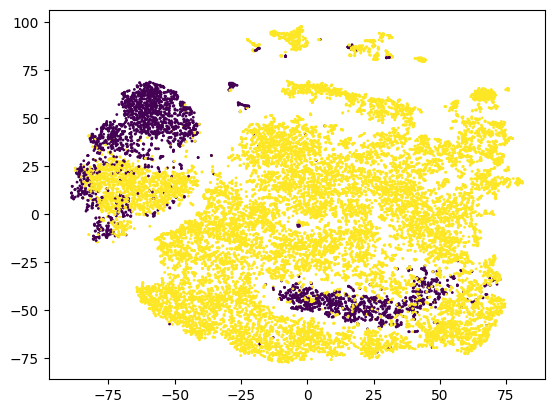

In [79]:
model = SwAV()
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
embeddings, targets = generate_embeddings(model, dataloader)

print("Calculating principal components...")
pca = PCA(50, random_state=42)
pca_embeddings = pca.fit_transform(embeddings.cpu())

print("Performing T-distributed Stochastic Neighbor Embedding...")
tsne = TSNE()
tsne_embeddings = tsne.fit_transform(pca_embeddings)

print("Plotting t-SNE...")
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=1, c=targets)
plt.show()